In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import scqubits as scq
from scqubits import HilbertSpace, InteractionTerm, ParameterSweep

import numpy as np

np.set_printoptions(threshold=10, edgeitems=2)

In [2]:
# Define HilbertSpace object: two transmons coupled to an oscillator


tmon1 = scq.TunableTransmon(
    EJmax=40.0,
    EC=0.2,
    d=0.1,
    flux=0.23,
    ng=0.3,
    ncut=40,
    truncated_dim=3,     # after diagonalization, we will keep 3 levels
    id_str="tmon1"       # optional, used for referencing from within
                         # ParameterSweep or HilbertSpace
)

tmon2 = scq.TunableTransmon(
    EJmax=15.0,
    EC=0.15,
    d=0.2,
    flux=0.0,
    ng=0.0,
    ncut=30,
    truncated_dim=3,
    id_str="tmon2"
)

resonator = scq.Oscillator(
    E_osc=4.5,
    truncated_dim=4    # up to 3 photons (0,1,2,3)
)

hilbertspace = scq.HilbertSpace([tmon1, tmon2, resonator])


g1 = 0.1  # coupling resonator-CPB1 (without charge matrix elements)
g2 = 0.2  # coupling resonator-CPB2 (without charge matrix elements)

hilbertspace.add_interaction(
    g_strength = g1,
    op1 = tmon1.n_operator,
    op2 = resonator.creation_operator,
    add_hc = True,
    id_str="tmon1-resonator"  # optional keyword argument
)

hilbertspace.add_interaction(
    g_strength = g2,
    op1 = tmon2.n_operator,
    op2 = resonator.creation_operator,
    add_hc = True,
    id_str="tmon2-resonator"  # optional keyword argument
)

In [3]:
# Set up parameter name and values
pname1 = 'flux'  
flux_vals = np.linspace(0.0, 2.0, 171)
pname2 = 'ng'
ng_vals = np.linspace(-0.5, 0.5, 49)

# combine into a dictionary
paramvals_by_name = {pname1: flux_vals, pname2: ng_vals}


area_ratio = 1.2

def update_hilbertspace(flux, ng):  # function that defines how Hilbert space components are updated
    tmon1.flux = flux
    tmon2.flux = area_ratio * flux
    tmon2.ng = ng

# dictionary with information on which subsystems are affected by changing parameters    
subsys_update_info = {pname1: [tmon1, tmon2],
                      pname2: [tmon2]}

    
# create the ParameterSweep    
sweep = ParameterSweep(
    hilbertspace=hilbertspace,
    paramvals_by_name=paramvals_by_name,
    update_hilbertspace=update_hilbertspace,
    evals_count=20,
    subsys_update_info=subsys_update_info,
    num_cpus=4
)

Parallel compute bare eigensys for subsystem tmon1 [num_cpus=4]

Parallel compute bare eigensys for subsystem tmon2 [num_cpus=4]

Parallel compute bare eigensys for subsystem Oscillator_1 [num_cpus=4]

Parallel compute dressed eigensys [num_cpus=4]

## Transition plots
Energy spectra obtained in single-tone or two-tone spectroscopy always represent transitions energies, rather than absolute energies of individual eigenstates. To generate data mimicking this, appropriate differences between eigenenergies must be taken.

The methods for generating transition energy data and plotting them are `<ParameterSweep>.transitions(...)` and `<ParameterSweep>.plot_transitions(...)`. To create a plot, we  use **"pre-slicing"** of the `ParameterSweep` instance to specify a sweep along a single axis, and then call `.plot_transitions()`.

.. note::
    **Pre-slicing** applies to `ParameterSweep` objects. It uses numpy or generalized slicing notation to 
    specify a subset of the sweep. For plotting, the resulting subset should be a one-dimensional sweep. Note that 
    pre-slicing does not actually discard any data. Rather, it internally marks the selected sub-sweep which is 
    then looked up when applying `.transitions()` or `plot_transitions()`.

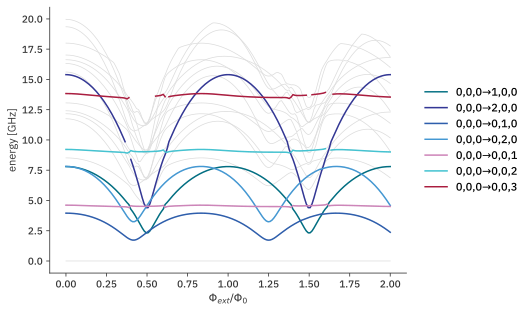

In [4]:
sweep["ng":0.0].plot_transitions();

The generated transition plot is based on default choices (most of which can be
overridden as needed):

* The origin of each transition is the state "closest" to the bare product state
  (0, 0,...,0).  In most cases, this will be the system's ground state. (Ultrastrong
  coupling may violate this.)
* By default, only single-photon transitions are included.
* Transitions are generally plotted in light grey. 
* By default, transitions among states of individual subsystems are marked separately
 and accompanied by a legend. This is possible in regions where the dispersive
 approximation holds, i.e., hybridization between subsystems remains weak and there
 is a 1-to-1 mapping between dressed states and bare product states.
* Labels in the legend are excitation levels of individual systems: ((0,0,0), (1,0,0)) denotes a transition from the ground state to the state with subsystem 1 (here: `tmon1`) in the first excited state, and subsystems 2 and 3 in their respective ground states.

One peculiarity is nearly unavoidable when coloring transitions according to the dispersive-limit state labeling: whenever states undergo avoided crossings and the dispersive limit breaks down, coloring must discontinuously switch from one branch to another. scqubits attempts to interrupt coloring in such regions. However, if the avoided crossing is so narrow that it occurs between two adjacent parameter values, then discontinuities from connecting separate branches will remain visible.

### Transition plot options
Multiple aspects of transition energy plots can be changed. The following gives a quick overview; see the API documentation for a comprehensive discussion of options.

#### `coloring`
If ordinary coloring is preferred, this can be obtained by choosing `"plain"` coloring:

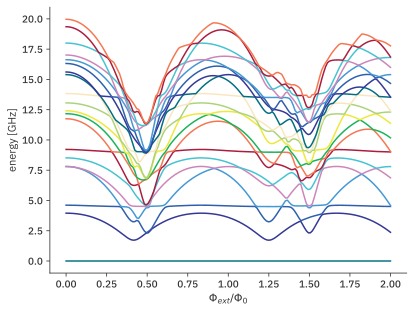

In [5]:
sweep["ng":0.0].plot_transitions(coloring="plain");

#### `subsystems`
When coloring transitions according to nature of the transition, all subsystems are included by default. If transitions for a single or smaller set of subsystem(s) should be highlighted, then these are specified in list form:

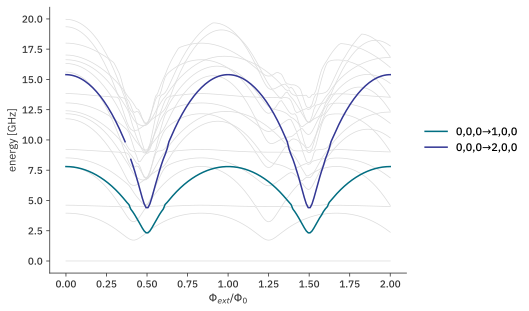

In [6]:
sweep["ng":0.0].plot_transitions(subsystems=[tmon1]);

#### `initial` and `final`
By default, the state closest to the bare product state (0,0,...,0)  is taken as origin for all transitions. (Except in cases of ultrastrong coupling, this is typically the ground state of the composite system.) In case of
thermal excitations, other states can be of interest as initial states. Specification
 of an alternative initial state can use dispersive labeling of states:

e.g., (1,0,0) uses the 1st excited `tmon1` state as the initial state:

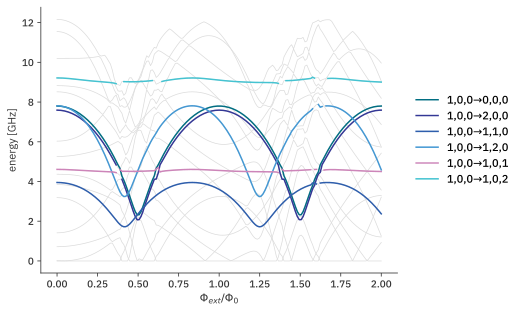

In [7]:
sweep["ng":0.0].plot_transitions(initial=(1,0,0));

Similarly, the `final` option may be used if only the transitions to a specific state
should be highlighted:

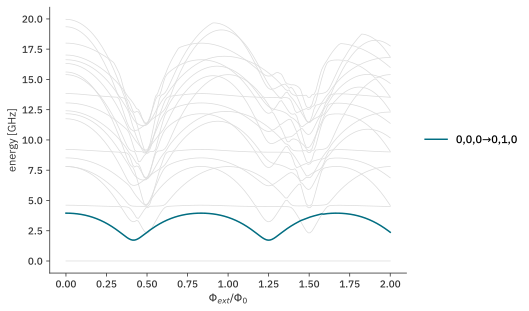

In [8]:
sweep["ng":0.0].plot_transitions(final=(0,1,0));

Overall, `initial` and `final` inputs of different kinds accommodate a variety of
situations:


* Tuples of integers for `initial` and/or `final` are interpreted as excitation numbers of bare product states. scqubits attempts an identification of dressed states with
    bare product states by considering maximum overlaps.
* Non-negative integer entries for `initial` and/or `final` refer to dressed-state indices (and lead to disabling of the `sidebands` and `subsystems` options).
* The option `final=-1` signals that all final states are selected for highlighting and are labeled via dressed-state indices.


#### `photon_number`
For **multi-photon transitions**, this keyword argument can be set to the number of photons involved in the transition. This results in division of the transition energies by `photon_number`.

#### `make_positive`
When considering excited as in the previous example, some of the transition energies will naturally be negative. Experimentally, these transitions are driven at the absolute frequency. By default, absolute values of transition energies are displayed. This can be disabled by setting `make_positive=False`.


#### `sidebands`
By default, sideband transitions are not highlighted. If set to true, sideband transitions with multiple subsystems changing excitation levels are included as well:

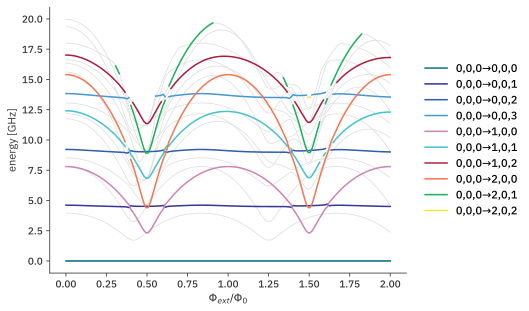

In [9]:
sweep["ng":0.0].plot_transitions(subsystems=[tmon1, resonator], sidebands=True);